<h1 align="center"> Geometric Methods in ML - ENSAE 2016/2017 </h1>
<h2 align="center"> Kernels approximation with Random Features </h2>
<h4 align="right"> <i>Author: Hicham Janati </i></h4>

<hr> 

<h2 align="center"><font color="blue"><i> I - Bochner theorem approximation    </i></font></h2>

Kernel approximation using Fourier random features relies on two properties: 

<div style="  
    padding: 10px;
    border: 5px solid gray;
    margin: 0; "> 
    If <br>
1- The Kernel K is shift-invariant: $K(\textbf{x}, \textbf{y}) = K(\textbf{z})$ where $ \textbf{x} - \textbf{y} = \textbf{z} $ <br>
2- The function $K(\textbf{z})$ is positive definite on $\mathbb{R}^d$
</div>
Then $$K \text{ is the Fourier transform of a finite-borel measure p on } \mathbb{R}^d $$ 

Thus, the Fourier transform can be written as an expectation w.r.t to the sampling distribution p leading to a Monte Carlo estimator. The algorithm major steps are: 

<h3 align="center"><font color="red">Random features Algorithm (Bochner): </font></h3> <br>

<div style="  
    padding: 10px;
    border: 5px solid gray;
    margin: 0; "> 
- Compute the Fourier transform of K: $$\mathcal{F}_K(w) = \frac{1}{(2\pi)^{\frac{d}{2}}} \int_{\mathbb{R}^d} K(\textbf{z}) e^{i\langle w,z \rangle} d\textbf{z} $$
- Sample $D$ $i.i.d$ vectors w from: $$p(\textbf{w}) = \frac{1}{(2\pi)^{\frac{d}{2}}} \mathcal{F}_K(w) $$
- Sample $D$  $i.i.d$ vectors b from the uniform distribution.
- Compute the new features $$Z(X) = \sqrt{\frac{2}{D}}\left[ cos(X.w_1 + u_1), \dots, cos(X.w_D + u_D) \right] $$
- Compute the Kernel estimates: $$ K(\textbf{x},\textbf{y}) = \langle Z(\textbf{x}), Z(\textbf{y}) \rangle $$ </div>

In [5]:
import numpy as np # Thinly−wrapped numpy
import pandas as pd
from matplotlib import cm 
import matplotlib as mpl
%matplotlib inline 
from matplotlib import pyplot as plt 
data = '../data/'

# The Random Fourier Features class
### Sampling distribution p(w):

This class concerns RF approximation of:
- RBF Kernel: $$K(z) = e^{-\gamma ||z^2||_2 } $$
For which the sampling distribution p is gaussian too : $$ w \sim \mathcal{N}\left(0,\sqrt{2\gamma}I_d\right) $$
- Laplacian Kernel: $$K(z) = e^{-\gamma ||z||_1 } $$ 
Here the sampling distribution is Cauchy (multinomial, uncorrelated components) $(\gamma)$: $$ p(w) = \frac{\gamma^2}{\pi\gamma\left(w^2 + \gamma^2\right)} $$

<font color="red" > The math is provided in Supplementary Materiel of our <a source="http://nbviewer.jupyter.org/github/hichamjanati/srf/tree/master/review-srf.pdf"> paper </a></font>

<hr>
### Python class
We implement a python class **RFF** that takes as input arguments:
- Kernel parameters 
- Number of MonteCarlo Samples D

    .The **fit** method generates  the random samples
    
    .The **transform** method computes the new features Z
    
    .The **compute_kernel** method computes the approxiamted Kernel gram-matrix
    

In [6]:
from sklearn.base import BaseEstimator
from sklearn.exceptions import NotFittedError
from scipy.stats import cauchy, laplace
from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel

class RFF(BaseEstimator):
    def __init__(self, gamma = 1, D = 50, metric = "rbf"):
        self.gamma = gamma
        self.metric = metric
        #Dimensionality D (number of MonteCarlo samples)
        self.D = D
        self.fitted = False
        
    def fit(self, X, y=None):
        """ Generates MonteCarlo random samples """
        d = X.shape[1]
        #Generate D iid samples from p(w) 
        if self.metric == "rbf":
            self.w = np.sqrt(2*self.gamma)*np.random.normal(size=(self.D,d))
        elif self.metric == "laplace":
            self.w = cauchy.rvs(scale = self.gamma, size=(self.D,d))
        
        #Generate D iid samples from Uniform(0,2*pi) 
        self.u = 2*np.pi*np.random.rand(self.D)
        self.fitted = True
        return self
    
    def transform(self,X):
        """ Transforms the data X (n_samples, n_features) to the new map space Z(X) (n_samples, n_components)"""
        if not self.fitted:
            raise NotFittedError("RBF_MonteCarlo must be fitted beform computing the feature map Z")
        #Compute feature map Z(x):
        Z = np.sqrt(2/self.D)*np.cos((X.dot(self.w.T) + self.u[np.newaxis,:]))
        return Z
    
    def compute_kernel(self, X):
        """ Computes the approximated kernel matrix K """
        if not self.fitted:
            raise NotFittedError("RBF_MonteCarlo must be fitted beform computing the kernel matrix")
        Z = self.transform(X)
        K = Z.dot(Z.T)
        return K
    

## Simulation 
We evaluate the kernel approximation quality by computing the MSE between the gram matrices: 
$$ MSE(K,K') = Mean((K-K')^2) $$ 

We simulate random data and compute both RBF and Gaussian kernels: 

In [8]:
#size of data
N_SAMPLES, DIM = 1000, 200 
X = np.random.randn(N_SAMPLES,DIM)

gamma = 2
#Number of monte carlo samples D
Ds = np.arange(1,5000,200)
K_rbf, K_laplace = rbf_kernel(X, gamma=gamma), laplacian_kernel(X,gamma=gamma)
errors_rbf, errors_laplace = [] , []

for D in Ds:
    GAUSS = RFF(gamma=gamma, D=D, metric="rbf")
    GAUSS.fit(X)
    K_rbf_a = GAUSS.compute_kernel(X)

    LAPLACE = RFF(gamma=gamma, D=D, metric="laplace")
    LAPLACE.fit(X)
    K_laplace_a = LAPLACE.compute_kernel(X)

    errors_rbf.append(((K_rbf_a-K_rbf)**2).mean())
    errors_laplace.append(((K_laplace_a-K_laplace)**2).mean())

errors_rbf, errors_laplace = np.array(errors_rbf), np.array(errors_laplace)

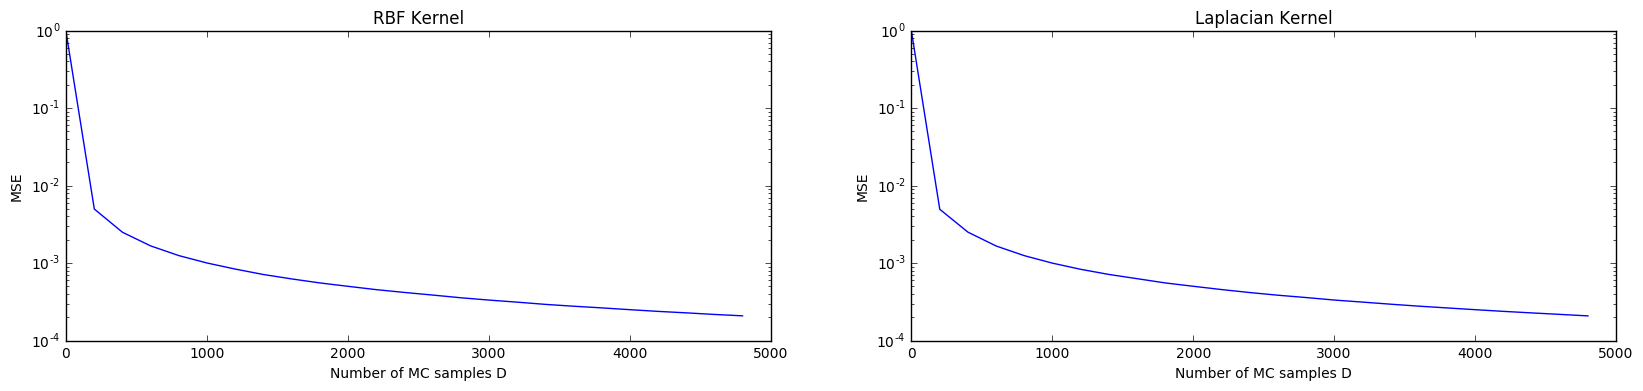

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,4))
for ax,data,title in zip(axes,[errors_laplace,errors_rbf],['RBF Kernel','Laplacian Kernel']):
    ax.plot(Ds, data)
    ax.set_ylabel("MSE")
    ax.set_xlabel("Number of MC samples D")
    ax.set_yscale("log")
    ax.set_title(title)
plt.show()

# In the Next Notebook: 
- Experiments on real data (Gisette, USPS) 
- Computation time & MSE in function of the number of data samples and the dimension (n,d)

 <a href="http://nbviewer.jupyter.org/github/hichamjanati/srf/tree/master/RFF-II.ipynb"> Go to the next notebook </a></font>